In [1]:
import pandas as pd
import numpy as np

import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime as dt

In [2]:
train = pd.read_csv("../../Data/Price Prediction/train_pos.csv")
test = pd.read_csv("../../Data/Price Prediction/test_pos.csv")

In [3]:
train.date = pd.to_datetime(train.date)
test.date = pd.to_datetime(test.date)

## Train vs Test

In [4]:
# train: 2016 08 01 ~ 2018 07 31
# test: 2016 08 01 ~ 2018 03 31

train_copy = train.copy()
test_copy = test.copy()

train_date = train_copy.groupby('date')[['amount']].sum()
train_date = train_date.loc['2016-08-01': '2018-03-31']
test_date = test_copy.groupby('date')[['amount']].sum()

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = MaxAbsScaler()
# scaler = RobustScaler()

scaler.fit(train_date)
train_date = scaler.transform(train_date)

scaler.fit(test_date)
test_date = scaler.transform(test_date)

In [6]:
temp1 = pd.DataFrame(train_date, columns=['train_date_amount'])
temp2 = pd.DataFrame(test_date, columns=['test_date_amount'])
temp = pd.concat([temp1, temp2], axis=1)
temp.index = pd.date_range(test.date.min(), test.date.max(), freq = "D")

In [ ]:

"""
plt.subplot(2, 2, 1)
plt.plot(temp)
plt.title("1 Day")

plt.subplot(2, 2, 2)
plt.plot(temp.resample('7D').mean())
plt.title("7 Days")

plt.subplot(2, 2, 3)
plt.plot(temp.resample('14D').mean())
plt.title("14 Days")

plt.subplot(2, 2, 4)
plt.plot(temp.resample('30D').mean())
plt.title("30 Days")

plt.show()
"""

### 1 Day, 7 Days, 14 Days, 1 Month

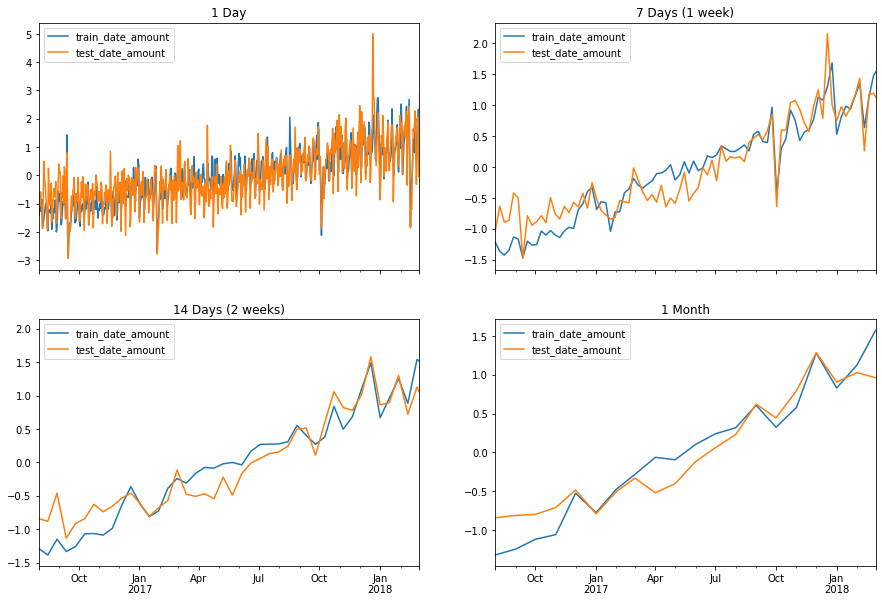

In [323]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(15,10))

temp.plot(ax=axes[0,0])
axes[0,0].set_title("1 Day")

temp.resample('7D').mean().plot(ax=axes[0,1])
axes[0,1].set_title("7 Days (1 week)")

temp.resample('14D').mean().plot(ax=axes[1,0])
axes[1,0].set_title("14 Days (2 weeks)")

temp.resample('M').mean().plot(ax=axes[1,1])
axes[1,1].set_title("1 Month")

plt.show()

### Seasonal

C:\Users\lonj7\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  after removing the cwd from sys.path.
C:\Users\lonj7\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """


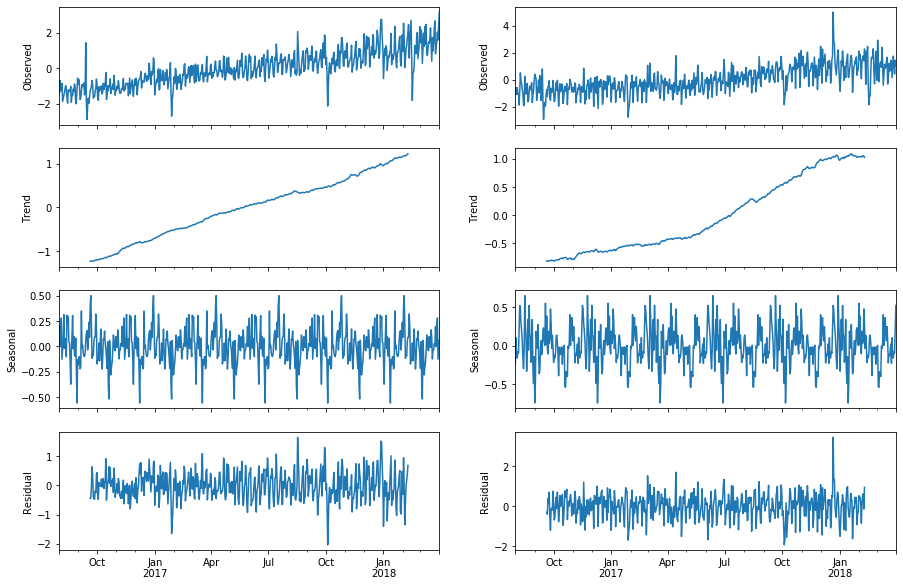

In [327]:
import statsmodels.api as sm
from pylab import rcParams

train_amount= sm.tsa.seasonal_decompose(temp.train_date_amount,freq=100) # The frequncy is 30 days
test_amount= sm.tsa.seasonal_decompose(temp.test_date_amount,freq=100) # The frequncy is 30 days

def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')


fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(15,10))
plotseasonal(train_amount, axes[:,0])
plotseasonal(test_amount, axes[:,1])
plt.show()

### Day of week

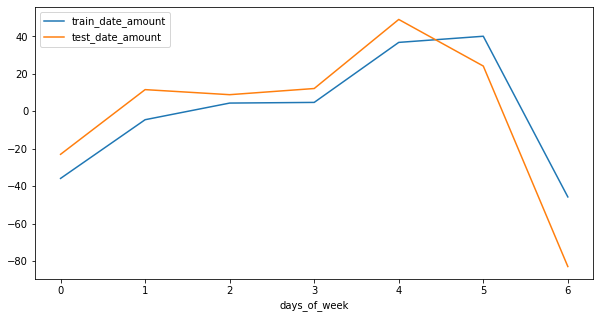

In [332]:
temp['days_of_week'] =  temp.index.dayofweek
temp.groupby("days_of_week").sum().plot(figsize=(10,5))

In [333]:
# train셋과 test셋의 그래프들이 대충 비슷하게 나옴

## Heirarchical clustering

In [5]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster, ward, dendrogram

In [129]:
# given a linkage model, plog dendogram, with the colors indicated by the a cutoff point at which we define clusters
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

In [224]:
def hierarchical_clustering(data):
    name_of_stores = data.store_id.unique()
    all_times = pd.date_range(data.date.min(), data.date.max(), freq = "D")
    
    temp = data[['store_id', 'date', 'amount']].copy()
    temp = temp.groupby(['store_id', 'date'], as_index=False).sum()
    
    
    list_of_stores = pd.DataFrame(index = all_times)
    for name in name_of_stores:
        temp1 = temp[temp['store_id']==name].groupby("date")[['amount']].sum().reindex(all_times).fillna(0)
        store_i =  "store_%s" %(str(name))
        list_of_stores[store_i] = temp1    
    
    # scale
    scaler = StandardScaler()
    scaler.fit(list_of_stores)
    list_of_stores_scaled = scaler.transform(list_of_stores)
    
    list_of_stores_scaled = pd.DataFrame(list_of_stores_scaled, columns=list_of_stores.columns)
    
    # cluster
    clf = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(list_of_stores_scaled.T)
    
    plt.figure(figsize = (14,6))
    plt.title('Hierarchical Clustering Dendrogram')
    # plot the top three levels of the dendrogram
    Z = plot_dendrogram(clf, p=5, color_threshold = 110)
    plt.show()
    
    return clf, Z, list_of_stores_scaled

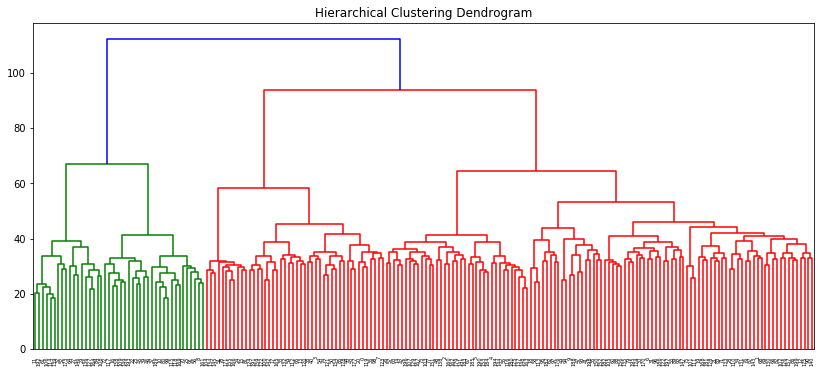

In [225]:
test_model, Z_test, test_stores = hierarchical_clustering(test_copy)

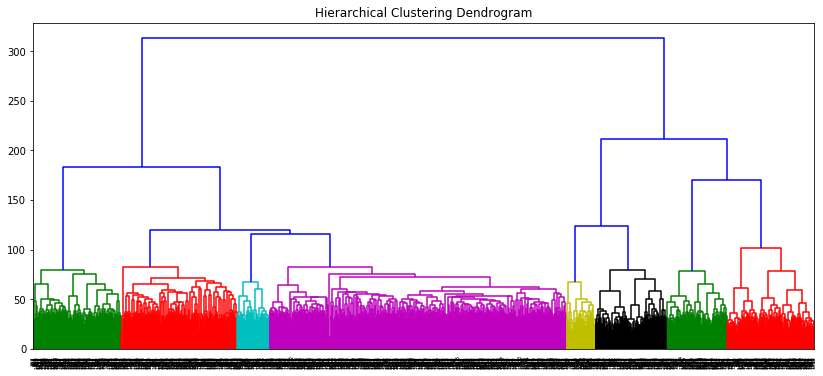

In [226]:
train_model, Z_train, train_stores = hierarchical_clustering(train_copy)

In [259]:
# extract clusters from dendogram
clusters = fcluster(Z_train, 100, criterion='distance')
# create a lookup table for series in a given cluster
train_stores_clustered = train_stores.T.reset_index()
train_stores_clustered["cluster"] = clusters
train_stores_clustered.rename(columns = {'index' : 'store_id'}, inplace = True)
train_stores_clustered = train_stores_clustered.groupby(['cluster', 'store_id']).mean()

In [260]:
train_stores_clustered

0         1         2         3         4    \
cluster store_id                                                       
1       store_100  -0.413309 -0.671770 -0.284078  0.753212 -0.094540   
        store_1002  0.347186  0.828229 -0.096853  0.539141 -0.048286   
        store_1019 -0.680262  0.128164 -0.662069 -0.605906 -0.219095   
        store_1022  3.023914 -0.222569  0.030597 -0.031454  1.174808   
        store_1023  1.735614  2.019358  0.870873  1.445115 -0.946434   
...                      ...       ...       ...       ...       ...   
9       store_883  -0.633094 -0.633094 -0.633094 -0.633094 -0.633094   
        store_912  -0.531772 -0.531772 -0.531772 -0.531772 -0.531772   
        store_923  -0.856638 -0.856638 -0.856638 -0.856638 -0.856638   
        store_929  -0.453258 -0.453258 -0.453258 -0.453258 -0.453258   
        store_976  -0.461300 -0.461300 -0.461300 -0.461300 -0.461300   

                         5         6         7         8         9    ...  \
cluster store_id                                                      ...   
1       store_100  -0.327155  0.353459  0.698074 -0.671770 -0.134171  ...   
        store_1002  2.458687  0.498668 -1.027717  0.209580  2.559289  ...   
        store_1019  0.912860 -0.557653 -0.123381  0.170089  0.117881  ...   
        store_1022  1.145024 -0.031454 -0.207677 -0.284620 -0.284620  ...   
        store_1023  0.729002 -0.041158  1.141105  0.458770  0.614153  ...   
...                      ...       ...       ...       ...       ...  ...   
9       store_883  -0.633094 -0.633094 -0.633094 -0.633094 -0.633094  ...   
        store_912  -0.531772 -0.531772 -0.531772 -0.531772 -0.531772  ...   
        store_923  -0.856638 -0.856638 -0.856638 -0.856638 -0.856638  ...   
        store_929  -0.453258 -0.453258 -0.453258 -0.453258 -0.453258  ...   
        store_976  -0.461300 -0.461300 -0.461300 -0.461300 -0.461300  ...   

                         720       721       722       723       724  \
cluster store_id                                                       
1       store_100   1.611303 -0.439155  0.405151 -0.671770 -0.671770   
        store_1002  1.825005  1.408718  0.984337 -0.079508 -0.021690   
        store_1019  0.783132 -1.015656 -1.078938 -0.460357  0.913651   
        store_1022 -0.172929 -0.284620 -0.284620 -0.284620 -0.284620   
        store_1023  0.472282  2.046381  0.519572  0.269608 -0.149251   
...                      ...       ...       ...       ...       ...   
9       store_883   0.239699  0.733696 -0.164480  0.333422 -0.057090   
        store_912   2.115740  2.177670  0.861655  3.276929  3.261446   
        store_923   4.491075  2.667186  2.448791  2.159566  2.271715   
        store_929  -0.453258  0.305070 -0.453258  2.293577  0.203960   
        store_976  -0.461300  1.680856  1.573260  0.008214 -0.461300   

                         725       726       727       728       729  
cluster store_id                                                      
1       store_100  -0.335770 -0.284078  2.291917  0.336228 -0.568385  
        store_1002  4.186278  0.720688  2.001927 -1.027717  1.776438  
        store_1019  0.399485 -0.359897  0.203312 -0.481715 -0.662069  
        store_1022 -0.135699  1.862328  0.013223 -0.210159 -0.284620  
        store_1023  1.526185  0.492549 -1.547700  0.485793 -1.135597  
...                      ...       ...       ...       ...       ...  
9       store_883  -0.633094 -0.633094  0.001487  0.460338 -0.437838  
        store_912   2.858901 -0.531772  1.248718  0.536522  6.636636  
        store_923   1.162035  2.667186  2.962313  2.714406  2.218592  
        store_929   1.130806 -0.453258 -0.453258 -0.453258 -0.453258  
        store_976   1.954740 -0.334140  0.957023  1.240687  0.908115  

[1663 rows x 730 columns]

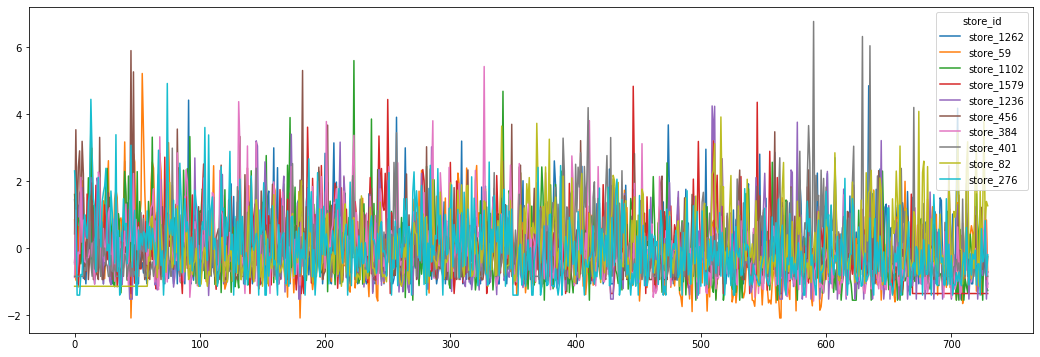

In [261]:
import random

# cluster 1
random.seed(1)
train_stores_clustered.loc[1].T.iloc[:, random.sample(range(train_stores_clustered.loc[1].shape[0]), 10)].plot(figsize = (18,6))

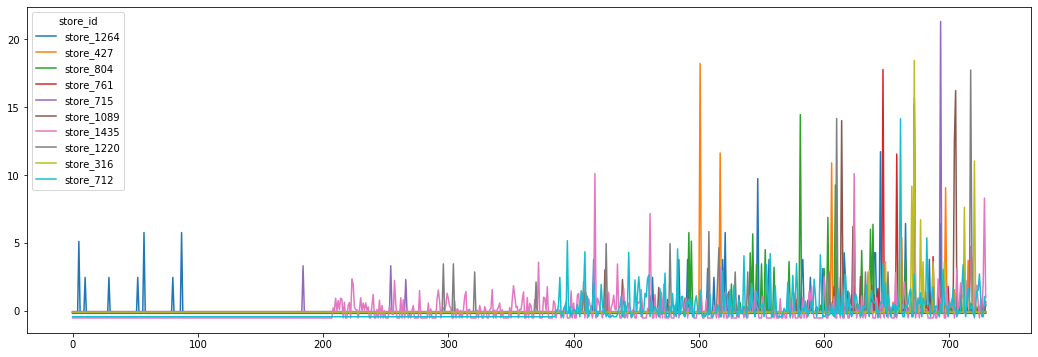

In [262]:
# cluster 2

random.seed(1)
train_stores_clustered.loc[2].T.iloc[:, random.sample(range(train_stores_clustered.loc[2].shape[0]), 10)].plot(figsize = (18,6))

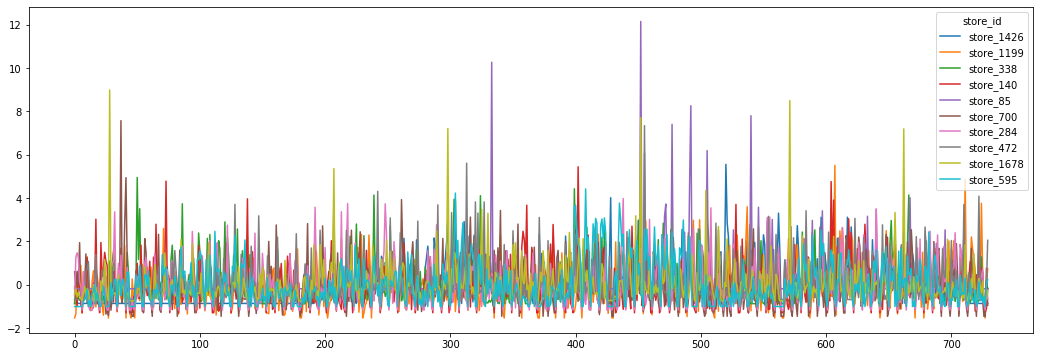

In [263]:
# cluster 3

random.seed(1)
train_stores_clustered.loc[3].T.iloc[:, random.sample(range(train_stores_clustered.loc[3].shape[0]), 10)].plot(figsize = (18,6))

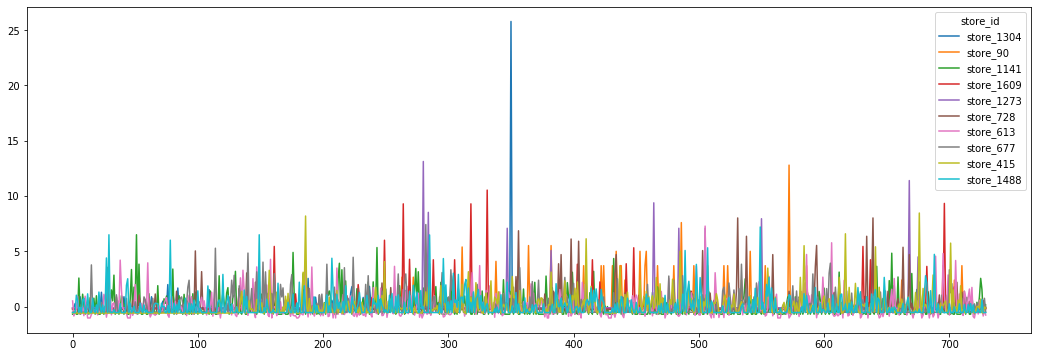

In [264]:
# cluster 4

random.seed(1)
train_stores_clustered.loc[4].T.iloc[:, random.sample(range(train_stores_clustered.loc[4].shape[0]), 10)].plot(figsize = (18,6))

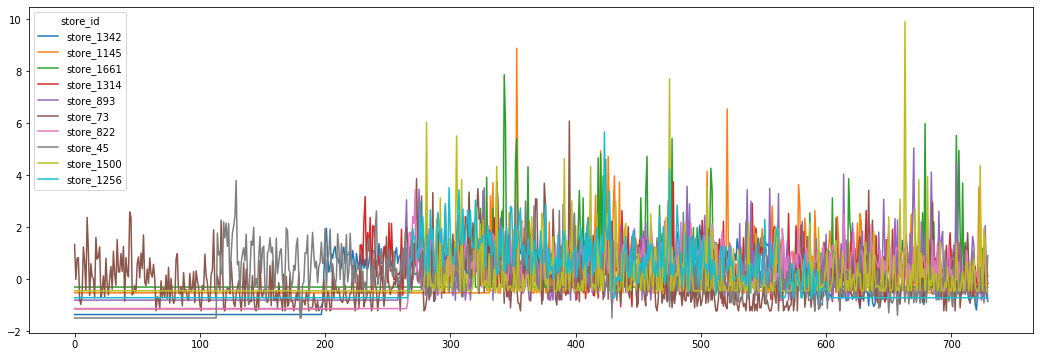

In [265]:
# cluster 7

random.seed(1)
train_stores_clustered.loc[7].T.iloc[:, random.sample(range(train_stores_clustered.loc[7].shape[0]), 10)].plot(figsize = (18,6))

## Dynamic Time Warping

In [282]:
import itertools
from dtw import *

def get_dtw_diff_matrix(cols:list):
    """
    From a list of series, compute a distance matrix by computing the 
    DTW distance of all pairwise combinations of series.
    """
    diff_matrix = {}
    cross = itertools.product(cols, cols)
    for (col1, col2) in cross:
        series1 = train_stores[col1]
        series2 = train_stores[col2]
        diff = dtw(
            series1, 
            series2,
            keep_internals=True, 
            step_pattern=rabinerJuangStepPattern(2, "c")
            )\
            .normalizedDistance
        diff_matrix[(col1, col2)] = [diff]
    return diff_matrix

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [283]:
# sample 50 series, and compute the DTW distance matrix
random.seed(1)
sample_cols = random.sample(list(train_stores.columns), 50)
dtw_diff_dict = get_dtw_diff_matrix(sample_cols)
# make into a df
dtw_diff_df = pd.DataFrame(dtw_diff_dict).T.reset_index()\
    .rename(columns = {"level_0":"item1", "level_1":"item2", 0:"diff"})\
    .pivot_table(index = "item1", columns = "item2", values = "diff")

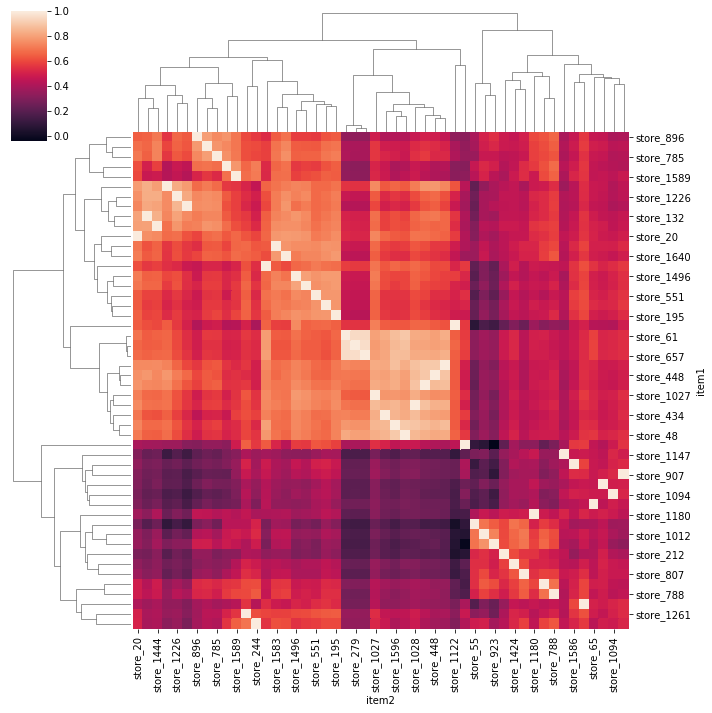

In [284]:
sns.clustermap(1-dtw_diff_df)

In [29]:
name_of_stores = test_copy.store_id.unique()
all_times = pd.date_range(test.date.min(), test.date.max(), freq = "D")

In [30]:
temp = test_copy[['store_id', 'date', 'amount']].copy()
temp = temp.groupby(['store_id', 'date'], as_index=False).sum()

In [45]:
list_of_stores = pd.DataFrame(index = all_times)

for name in name_of_stores:
    temp1 = temp[temp['store_id']==name].groupby("date")[['amount']].sum().reindex(all_times).fillna(0)
    list_of_stores[name] = temp1

In [47]:
list_of_stores.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
2016-08-01,2106.0,0.0,647.0,199.0,279.0,0.0,718.0,0.0,0.0,0.0,...,35.0,0.0,0.0,0.0,935.0,0.0,3600.0,300.0,0.0,0.0
2016-08-02,1528.0,0.0,270.0,653.0,236.0,0.0,1086.0,0.0,0.0,0.0,...,75.0,940.0,0.0,0.0,440.0,1520.0,500.0,0.0,0.0,0.0
2016-08-03,560.0,150.0,240.0,480.0,400.0,30.0,758.0,0.0,0.0,0.0,...,395.0,576.0,0.0,0.0,1645.0,1005.0,2387.0,0.0,0.0,985.0
2016-08-04,1683.0,0.0,160.0,403.0,395.0,0.0,702.0,0.0,0.0,0.0,...,395.0,960.0,0.0,0.0,400.0,795.0,1000.0,0.0,15.0,830.0
2016-08-05,1686.0,0.0,629.0,382.0,99.0,63.0,1271.0,0.0,0.0,0.0,...,75.0,767.0,0.0,0.0,1040.0,1330.0,0.0,0.0,0.0,648.0


In [285]:
# ward clustering from difference matrix, where distance is Dynamic time warping distance instead of Euclidean
t = ward(dtw_diff_df)
# extract clusters
dtw_clusters = pd.DataFrame({"cluster":fcluster(t, 1.15)}, index = dtw_diff_df.index)

Text(0.5, 1.0, 'Frequency of DTW clusters')

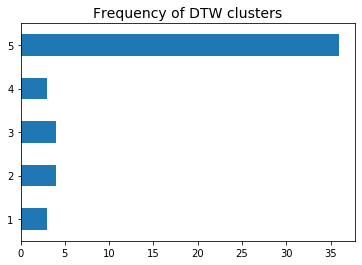

In [286]:
dtw_clusters.cluster.value_counts().sort_index().plot.barh()
plt.title("Frequency of DTW clusters", fontsize = 14)

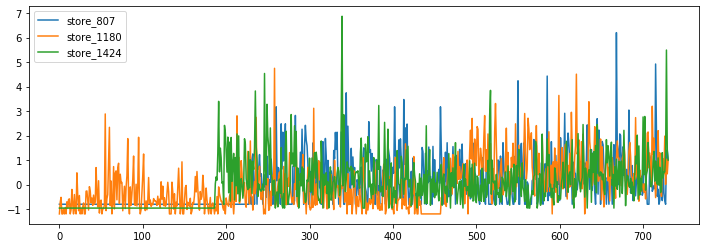

In [287]:
# cluster 1
train_stores.T.merge(
    dtw_clusters.loc[dtw_clusters.cluster == 1], 
    left_index = True,
    right_index = True
)\
    .T\
    .plot(figsize = (12,4))

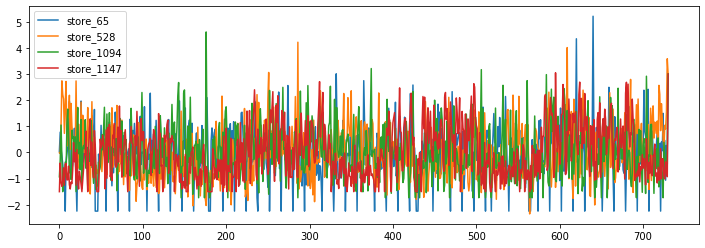

In [290]:
# cluster 3
train_stores.T.merge(
    dtw_clusters.loc[dtw_clusters.cluster == 3], 
    left_index = True,
    right_index = True
)\
    .T\
    .plot(figsize = (12,4))

## 7Days + Heirarchical clustering

In [6]:
# given a linkage model, plog dendogram, with the colors indicated by the a cutoff point at which we define clusters
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

In [14]:
temp = train[['store_id', 'date', 'amount']].copy()
temp = temp.groupby(['store_id', 'date'], as_index=False).sum()
all_times = pd.date_range(train.date.min(), train.date.max(), freq = "D")

In [15]:
temp1 = temp[temp['store_id']==0].groupby("date")[['amount']].sum().reindex(all_times).fillna(0)
temp1 = temp1.resample('7D').sum()

In [16]:
temp1

,amount
2016-08-01,0.0
2016-08-08,0.0
2016-08-15,0.0
2016-08-22,0.0
2016-08-29,0.0
...,...
2018-07-02,64580.0
2018-07-09,61480.0
2018-07-16,62786.0
2018-07-23,58993.0


In [52]:
def hierarchical_clustering(data):
    name_of_stores = data.store_id.unique()
    all_times = pd.date_range(data.date.min(), data.date.max(), freq = "D")
    
    temp = data[['store_id', 'date', 'amount']].copy()
    temp = temp.groupby(['store_id', 'date'], as_index=False).sum()
    
    
    list_of_stores = pd.DataFrame(index = all_times)
    list_of_stores = list_of_stores.resample('14D').sum()
    
    for name in name_of_stores:
        temp1 = temp[temp['store_id']==name].groupby("date")[['amount']].sum().reindex(all_times).fillna(0)
        temp1 = temp1.resample('7D').sum()
        store_i =  "store_%s" %(str(name))
        list_of_stores[store_i] = temp1    
    
    # scale
    # scaler = StandardScaler()
    # scaler = MinMaxScaler()
    # scaler = MaxAbsScaler()
    scaler = RobustScaler()
    scaler.fit(list_of_stores)
    list_of_stores_scaled = scaler.transform(list_of_stores)
    
    list_of_stores_scaled = pd.DataFrame(list_of_stores_scaled, columns=list_of_stores.columns)
    
    # cluster
    clf = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(list_of_stores_scaled.T)
    
    plt.figure(figsize = (14,6))
    plt.title('Hierarchical Clustering Dendrogram')
    # plot the top three levels of the dendrogram
    Z = plot_dendrogram(clf, p=5, color_threshold = 110)
    plt.show()
    
    return clf, Z, list_of_stores_scaled

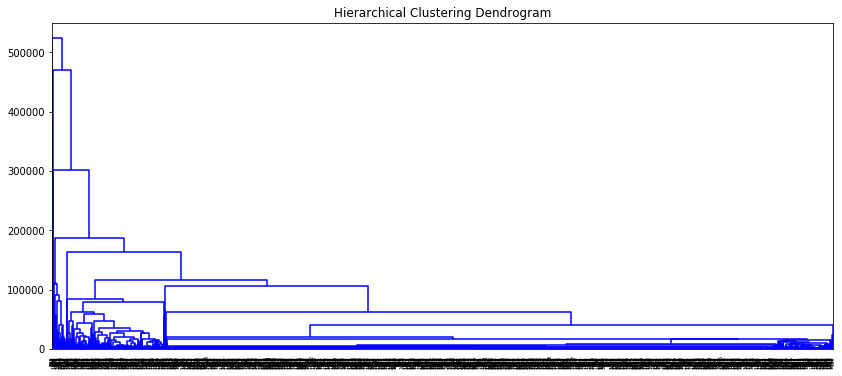

In [53]:
model_train, Z_train, train_stores = hierarchical_clustering(train_copy)

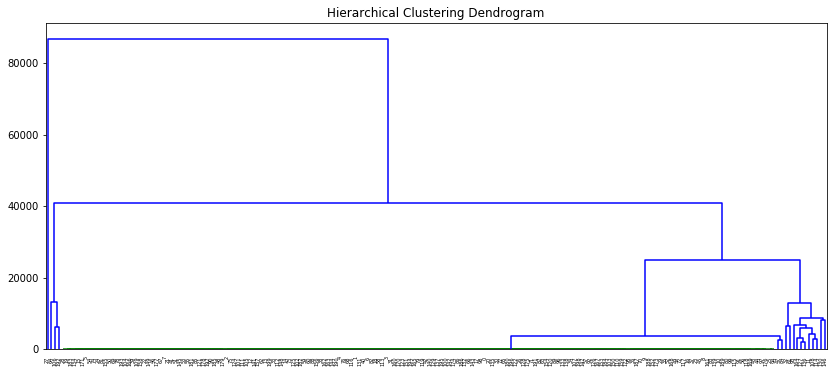

In [54]:
model_test, Z_test, test_stores = hierarchical_clustering(test_copy)

In [75]:
# extract clusters from dendogram
# criterion='maxclust'
clusters = fcluster(Z_test, 20000, criterion='distance')
# create a lookup table for series in a given cluster
test_stores_clustered = test_stores.T.reset_index()
test_stores_clustered["cluster"] = clusters
test_stores_clustered.rename(columns = {'index' : 'store_id'}, inplace = True)
test_stores_clustered = test_stores_clustered.groupby(['cluster', 'store_id']).mean()

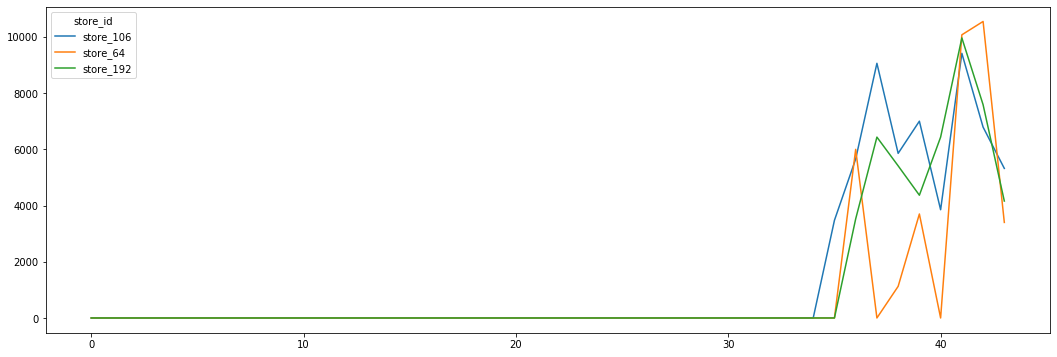

In [80]:
# cluster 1
import random

random.seed(1)
test_stores_clustered.loc[1].T.iloc[:, random.sample(range(test_stores_clustered.loc[1].shape[0]), 3)].plot(figsize = (18,6))

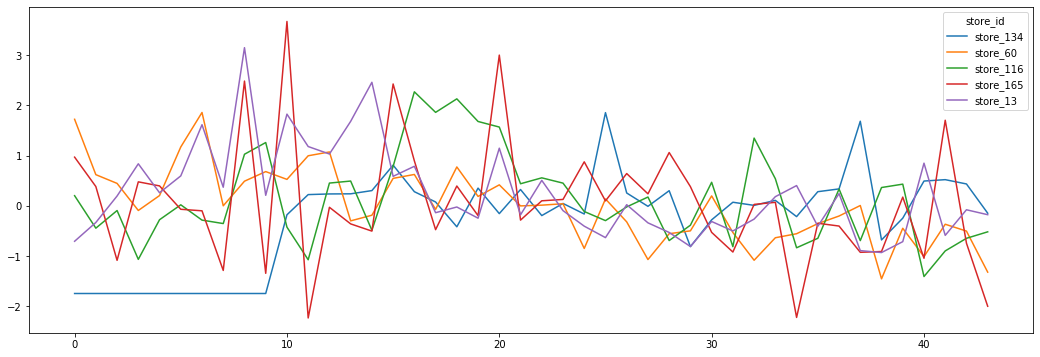

In [81]:
# cluster 2

random.seed(1)
test_stores_clustered.loc[2].T.iloc[:, random.sample(range(test_stores_clustered.loc[2].shape[0]), 5)].plot(figsize = (18,6))

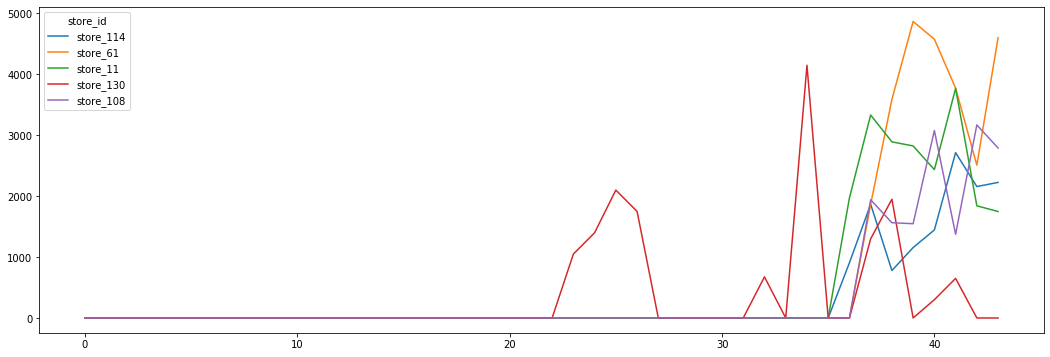

In [89]:
# cluster 3
random.seed(1)
test_stores_clustered.loc[3].T.iloc[:, random.sample(range(test_stores_clustered.loc[3].shape[0]), 5)].plot(figsize = (18,6))

In [ ]:
1600 847 334

## delete data from train set
- 한 달에 거래 횟수가 5회 이하인 곳
- 2018 03 31 이후 일정 기간동안 영업활동이 없는 곳

In [391]:
# 한 달에 거래 횟수가 5회 이하인 곳

train_ = train.copy()
train_['count'] = 1

In [406]:
a = train_[train_['store_id']==0].groupby('date')[['count']].sum().resample('M').sum()

In [414]:
len(a[a['count'] < 5]) == 0

True

In [415]:

if len(a[a['count'] < 5]) != 0:
    print('aa')

In [420]:
store_names = train_.store_id.unique()
less_than_5 = []

for name in store_names:
    temp = train_[train_['store_id']==name].groupby('date')[['count']].sum().resample('M').sum()
        
    if len(temp[temp['count']<5] != 0):
        temp['store_id'] = name
        less_than_5.append(temp)

In [428]:
test

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,is_canceled
0,0,2016-08-01,00:28:15,bf33518373,125,NaN,0,0,0
1,0,2016-08-01,01:09:58,7a19a3a92f,90,NaN,0,0,0
2,0,2016-08-01,01:47:24,6f9fd7e241,150,NaN,0,0,0
3,0,2016-08-01,17:54:43,8bcf1d61b2,362,NaN,0,0,0
4,0,2016-08-01,18:48:53,6a722ce674,125,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...
457702,199,2018-03-30,14:17:59,300d7bc922,65,NaN,4,0,0
457703,199,2018-03-30,19:01:54,3ab757718b,65,NaN,4,0,0
457704,199,2018-03-30,20:08:03,2d8e9e421c,65,NaN,4,0,0
457705,199,2018-03-30,20:11:58,22daeb334e,200,NaN,4,0,0


In [431]:
store_names = test_.store_id.unique()
less_than_5 = []

for name in store_names:
    temp = test_[test_['store_id']==name].groupby('date')[['count']].sum().resample('M').sum()
        
    if len(temp[temp['count']<5] != 0):
        temp['store_id'] = name
        less_than_5.append(temp)
        
print(len(less_than_5))

30


In [423]:
for i in range(0,len(less_than_5)):
    if len(less_than_5[i]) < 10:
        print(i)

3
10
21
22
27
28
29
30
31
38
42
44
56
60
65
68
70
73
75
87
88
90
93
99
105
109
111
114
119
123
124
125
131
134
135
145
146
154
161
165
168
169
173
175
176
178
186
188
191
214
220
224
225
230
233
236
237
239
240
241
243
244
249
250
253
261
262
264
267
268
272
275
284
287
305
307
308
309
311
313
320
322
323
327
330
334
339
340
342
346
348
349
350
354
362
363
365
366
367
369
374
375
380
382
383
389
395
396
399
403
404
407
409
418
423
429
430
434
436
438
440
442
444
447
450
451
453
467
475
478
488
491
506
509
512
516
517
522
526
532
539
541
548
560
568
576
584
586
591
592
602
606
612
613
615
616
626
628
630
632
635
639
640
641
644
646
652
653
659
662
667
671


In [424]:
less_than_5[3]

,count,store_id
date,,
2017-08-31,1,9
2017-09-30,2,9
2017-10-31,0,9
2017-11-30,1,9
2017-12-31,2,9
2018-01-31,0,9
2018-02-28,3,9
2018-03-31,0,9
2018-04-30,2,9


#### Test

In [334]:
store_0 = test[test['store_id']==0][['date', 'days_of_week', 'holyday']].copy()
store_0['count'] = 1
store_0 = store_0.groupby("date").mean()

In [335]:
# all_times = 2016 08 01 ~ 2018 03 31
all_times = pd.date_range(test.date.min(), test.date.max(), freq = "D")
store_0 = store_0.reindex(all_times)

In [336]:
# 거래가 없는(비어있는) 날짜

store_0['holyday'].index[store_0['holyday'].apply(np.isnan)]

DatetimeIndex(['2016-10-23', '2017-10-11', '2017-12-13'], dtype='datetime64[ns]', freq=None)

In [337]:
# 비어있는 3개의 날짜 모두 휴일이 아님.

print(test[test['date']=='2016-10-23'].holyday.head(1))
print(test[test['date']=='2017-10-11'].holyday.head(1))
print(test[test['date']=='2017-12-13'].holyday.head(1))

4236    0
Name: holyday, dtype: int64
6691    0
Name: holyday, dtype: int64
4519    0
Name: holyday, dtype: int64


In [338]:
# store_0.fillna(0)

store_0.loc['2016-10-23'].holyday = 0
store_0.loc['2017-10-11'].holyday = 0
store_0.loc['2017-12-13'].holyday = 0

holyday = store_0.holyday

In [339]:
# 비어있는 3개의 요일

print(test[test['date']=='2016-10-23'].days_of_week.head(1))
print(test[test['date']=='2017-10-11'].days_of_week.head(1))
print(test[test['date']=='2017-12-13'].days_of_week.head(1))

4236    6
Name: days_of_week, dtype: int64
6691    2
Name: days_of_week, dtype: int64
4519    2
Name: days_of_week, dtype: int64


In [340]:
store_0.loc['2016-10-23'].days_of_week = 6
store_0.loc['2017-10-11'].days_of_week = 2
store_0.loc['2017-12-13'].days_of_week = 2
day_of_week = store_0['days_of_week']

In [341]:
store_list_test = []

test_ = test.copy()
test_['count'] = 1

all_times = pd.date_range(test.date.min(), test.date.max(), freq = "D")

for store_num in test.store_id.unique():
    temp = test_[test_['store_id']==0][['date', 'amount', 'count']].copy().groupby("date")[['amount', 'count']].sum()
    temp = pd.concat([temp, holyday, day_of_week], axis=1)
    
    store_list_test.append(temp)
    

In [346]:
temp = test_.groupby('store_id')[['amount', 'count']].sum()
temp['sales_per_trade'] = temp['amount'] / temp['count']

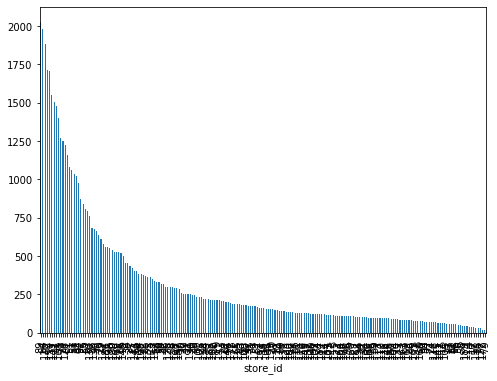

In [372]:
temp['sales_per_trade'].sort_values(ascending=False).plot(kind='bar', figsize=(8,6))

In [356]:
a = temp['sales_per_trade'].sort_values(ascending=False)

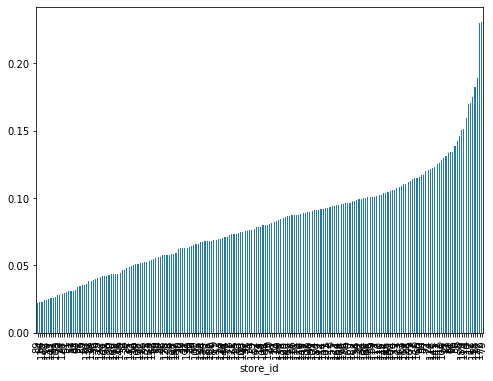

In [373]:
(1 / (a**(1/2))).plot(kind='bar', figsize=(8,6))

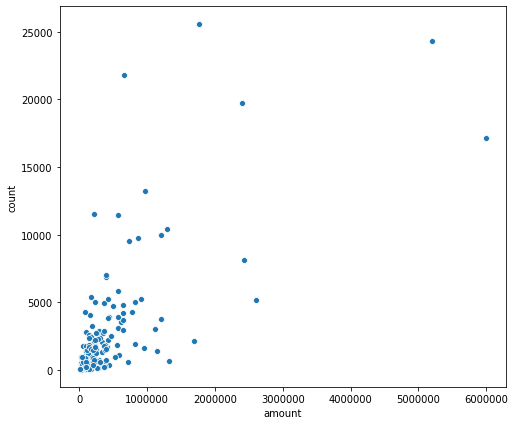

In [382]:
fig, ax = plt.subplots(figsize=(8,7))
sns.scatterplot(x='amount', y='count', data=temp, ax=ax)